In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted

%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install ta    
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install matplotlib
%pip install scikeras
%pip install keras-tuner
%pip install plotly
%pip install nbformat
%pip install lightgbm
%pip install seaborn
%pip install s3cmd
%pip install boto3
%pip install botocore    
%pip install s3
#%curl https://storage.yandexcloud.net/yandexcloud-yc/install.sh | bash -s -- -a    
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)



#print(f"Download completed. Local data dir: {data_dir}")

In [2]:
import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud;./download_data.sh")

In [3]:
strategy='LgbLowHighRegressionStrategy'
target_period='5min'
data_dir=f"../data/yandex-cloud/{strategy}"
#lib_dir='../.venv/lib/python3.11/site-packages'
history_days=2
comission_pct=0.012
quantity_coeff=1
#comission_pct=0


## Read prediction data


In [4]:
from pathlib import Path

def read_last_data(pattern, days=1):
    """ Read last days' files to one dataframe """

    xy_dir = Path(data_dir, 'Xy')
    files = sorted([f for f in os.listdir(xy_dir) if pattern in f])
    df = pd.concat([pd.read_csv(Path(xy_dir, fname), parse_dates=[0]) for fname in files[-days:]])
    print(f'Read {len(df)} data {pattern} rows  from {df.index.min()} to {df.index.max()}')
    return df
    #return df.set_index('datetime')    
def read_signal(days = 1):
    df = read_last_data('signal_status', days)
    return df.set_index('datetime')

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """

    df = read_last_data(f'raw_candles_{period}', days)
    df[['open_time','close_time']] =df[['open_time','close_time']].astype('datetime64[ns]')
    df = df.set_index('close_time', drop=False)
    # Resample because row data contains multiple candles inside a period
    print(f'Read {len(df)} candles from {df.index.min()} to {df.index.max()}')
    return df.resample(period).agg({'open_time': 'first', 'open': 'first', 'low': 'min', 'high': 'max', 'close': 'last', 'close_time': 'last'})

candles = read_candles(days=history_days, period=target_period)
signal_df = read_signal(days=history_days)
print(signal_df['signal'].value_counts())
signal_df.tail()

Read 27903 data raw_candles_5min rows  from 0 to 18875
Read 27903 candles from 2024-02-22 23:55:00 to 2024-02-24 17:40:00
Read 497 data signal_status rows  from 0 to 496
signal
0    491
1      6
Name: count, dtype: int64


signal       sl       tp    price  fut_low  fut_high  signal_buy  profit_buy  loss_buy  buy_ratio  signal_sell  profit_sell  loss_sell  sell_ratio  tr_delta         open_price status
datetime                                                                                                                                                                                                          
2024-02-24 16:42:08.948730       1  51209.1  51271.5  51215.2  51214.5   51271.5        True        44.0      13.0        3.4        False        -11.6       68.6        -0.2       6.1  already_in_market    NaN
2024-02-24 16:42:41.868104       0      NaN      NaN  51224.2  51215.2   51258.6       False        22.1      21.3        1.0        False         -3.3       46.7        -0.1       NaN         signal_oom    NaN
2024-02-24 16:43:12.998615       0      NaN      NaN  51224.1  51215.2   51258.6       False        22.2      21.2        1.0        False         -3.4       46.8        -0.1       NaN         signal_oom    NaN
2024-02-24 16:43:45.287241       0      NaN      NaN  51221.2  51212.6   51267.7       False        34.3      20.9        1.6        False         -3.7       58.8        -0.1       NaN         signal_oom    NaN
2024-02-24 16:44:16.290196       1  51209.2  51263.5  51215.3  51210.5   51263.5        True        35.9      17.1        2.1        False         -7.5       60.5        -0.1       6.1  already_in_market    NaN

In [5]:
signal_df.tail()

signal       sl       tp    price  fut_low  fut_high  signal_buy  profit_buy  loss_buy  buy_ratio  signal_sell  profit_sell  loss_sell  sell_ratio  tr_delta         open_price status
datetime                                                                                                                                                                                                          
2024-02-24 16:42:08.948730       1  51209.1  51271.5  51215.2  51214.5   51271.5        True        44.0      13.0        3.4        False        -11.6       68.6        -0.2       6.1  already_in_market    NaN
2024-02-24 16:42:41.868104       0      NaN      NaN  51224.2  51215.2   51258.6       False        22.1      21.3        1.0        False         -3.3       46.7        -0.1       NaN         signal_oom    NaN
2024-02-24 16:43:12.998615       0      NaN      NaN  51224.1  51215.2   51258.6       False        22.2      21.2        1.0        False         -3.4       46.8        -0.1       NaN         signal_oom    NaN
2024-02-24 16:43:45.287241       0      NaN      NaN  51221.2  51212.6   51267.7       False        34.3      20.9        1.6        False         -3.7       58.8        -0.1       NaN         signal_oom    NaN
2024-02-24 16:44:16.290196       1  51209.2  51263.5  51215.3  51210.5   51263.5        True        35.9      17.1        2.1        False         -7.5       60.5        -0.1       6.1  already_in_market    NaN

## Profit

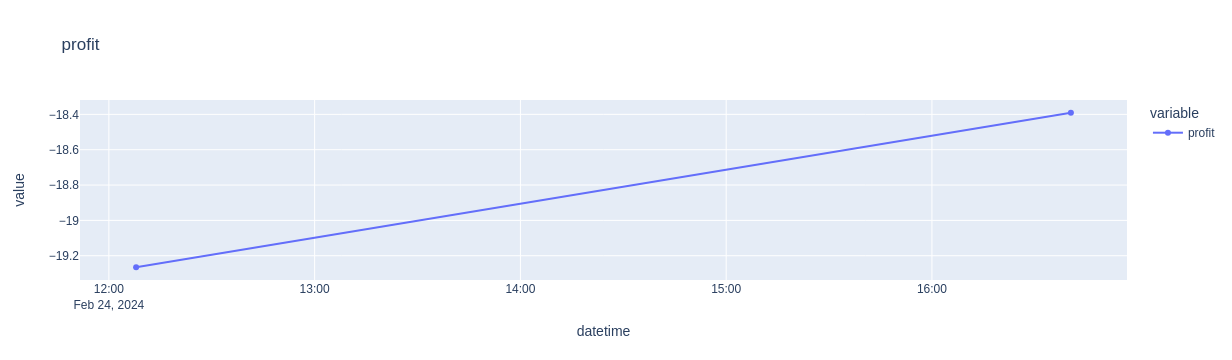

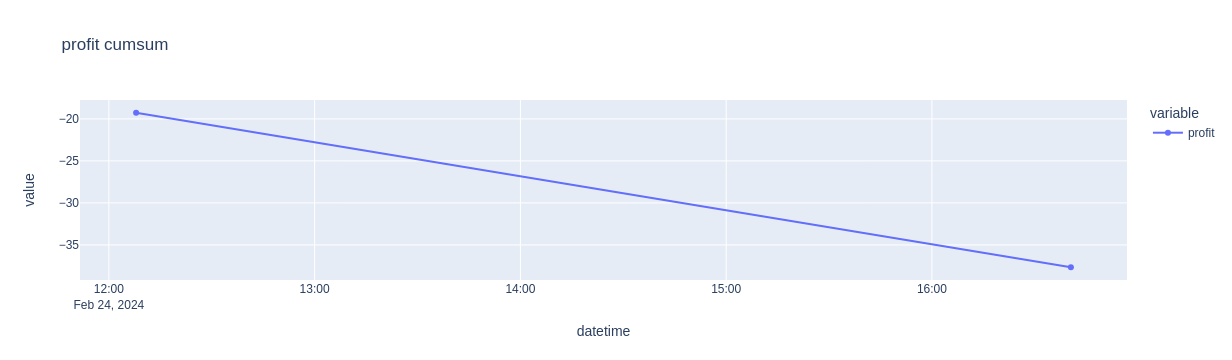

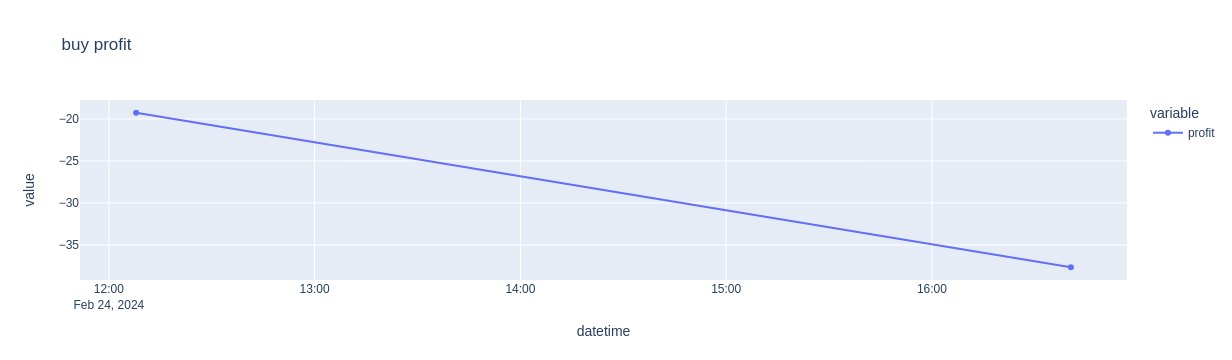

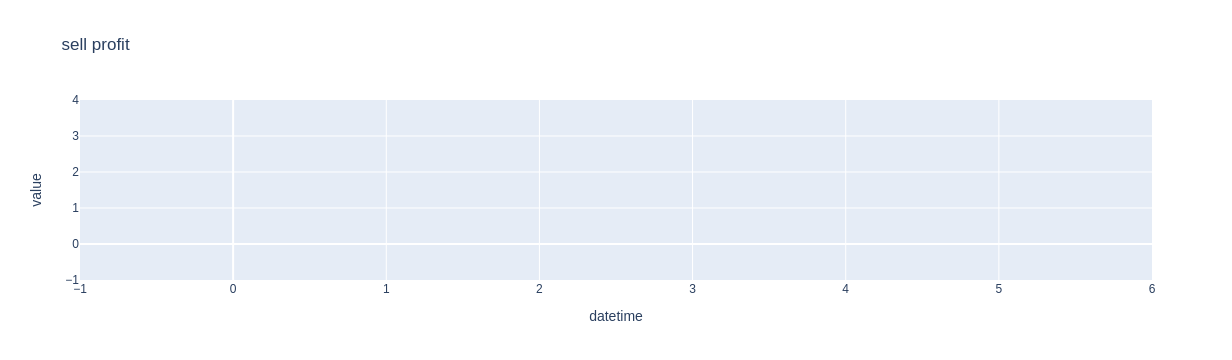

signal  raw_profit     profit
datetime                                              
2024-02-24 12:07:56.461       1        -7.0 -19.265272
2024-02-24 16:40:30.899       1        -6.1 -18.390808

In [6]:
import plotly.express as px
import warnings
# Supress pandas+plotly warning
warnings.simplefilter(action='ignore', category=FutureWarning)

def calc_profit(y_signal, fut_lohi, candles, target_period, signal_groups=False, timeout='1h', trailingstop=False):
    real_lohi = fut_lohi[['fut_low', 'fut_high']]
    real_lohi.columns=['fut_low_real', 'fut_high_real']

    y_signal = pd.merge_asof(y_signal.set_index(y_signal.index.astype('datetime64[ms]')),
                             real_lohi.set_index(real_lohi.index.astype('datetime64[ms]')), 
                             left_index=True, right_index=True, direction = 'backward')
    
    # Set profit/loss for 1 and -1, because 0 is excluded before
    loss = (y_signal['sl']-y_signal['price']).abs()
    profit = (y_signal['tp']-y_signal['price']).abs()
    if trailingstop:
        profit-=loss

    is_buy_profit = ((y_signal['signal']==1) 
                     & (y_signal['sl']< y_signal['fut_low_real'])
                     & (y_signal['tp'] <= y_signal['fut_high_real'])
                    )
    is_buy_loss = (y_signal['signal']==1) & (~is_buy_profit)

    is_sell_profit = ((y_signal['signal']==-1) 
                     & (y_signal['sl'] > y_signal['fut_high_real']) 
                     & (y_signal['tp'] >= y_signal['fut_low_real']))
    is_sell_loss = (y_signal['signal']==-1) & (~is_sell_profit)

    # Calc profit
    profit_df = y_signal[['signal']].copy()
    profit_df.loc[is_buy_profit | is_sell_profit,['raw_profit']] = profit
    profit_df.loc[is_buy_loss | is_sell_loss, 'raw_profit'] = -loss
    profit_df['raw_profit'] = profit_df['raw_profit'].fillna(0)
    # Minus open and close comissions
    profit_df['profit'] = profit_df['raw_profit'] - y_signal['signal'].abs()*y_signal['price']*comission_pct*0.01*2
    
    # Filter buy/sell  only
    if signal_groups:
        profit_df = profit_df.loc[(profit_df['signal']!=0) & (profit_df['signal'].diff())]
    else:
        profit_df = profit_df[profit_df['signal'] != 0]
    if timeout:
        timeout_delta = pd.Timedelta(timeout)
        is_timeout_denied = (profit_df.index.diff() < timeout_delta) & (profit_df['profit'].shift(1) < 0)
    
        while is_timeout_denied.sum():
            is_timeout_denied = (profit_df.index.diff() < timeout_delta) & (profit_df['profit'].shift(1) < 0)
            profit_df = profit_df[~is_timeout_denied]

    return profit_df

    
fut_lohi = candles[['low', 'high']].shift(-1).dropna().rename(columns={'low': 'fut_low', 'high': 'fut_high'})
profit_df = calc_profit(signal_df, fut_lohi, candles, target_period, False , '1h', True)
profit_df = calc_profit(signal_df, fut_lohi, candles, target_period, False , '1h', True)

px.line(profit_df[['profit']], title='profit').update_traces(mode='lines+markers').show()
px.line(profit_df[['profit']].cumsum(), title='profit cumsum').update_traces(mode='lines+markers').show()

px.line(profit_df.loc[profit_df['signal']==1, ['profit']].cumsum(), title='buy profit').update_traces(mode='lines+markers').show()
px.line(profit_df.loc[profit_df['signal']==-1, ['profit']].cumsum(), title='sell profit').update_traces(mode='lines+markers').show()
profit_df.tail()

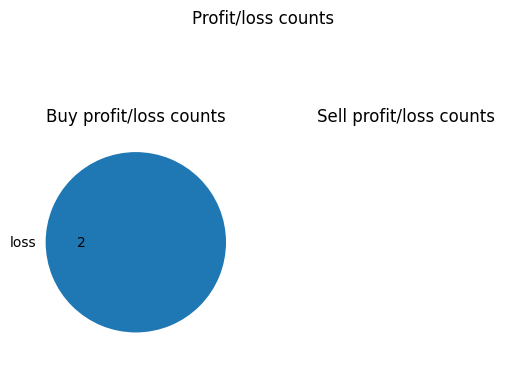

In [7]:
def plot_profit_pie(profit_df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    df = profit_df.copy()
    df.loc[df['profit'] > 0, 'profit_status'] = 'profit'
    df.loc[df['profit'] < 0, 'profit_status'] = 'loss'
    vc1 = df.loc[df['signal'] == 1, 'profit_status'].value_counts()
    ax1.pie(vc1, labels=vc1.keys(), autopct= lambda x: '{:.0f}'.format(x*vc1.sum()/100))
    ax1.set_title('Buy profit/loss counts')
                  
    vc2 = df.loc[df['signal'] == -1, 'profit_status'].value_counts()
    ax2.pie(vc2, labels=vc2.keys(), autopct= lambda x: '{:.0f}'.format(x*vc2.sum()/100))
    ax2.set_title('Sell profit/loss counts')
    fig.suptitle('Profit/loss counts')
    plt.show()

plot_profit_pie(profit_df)
    

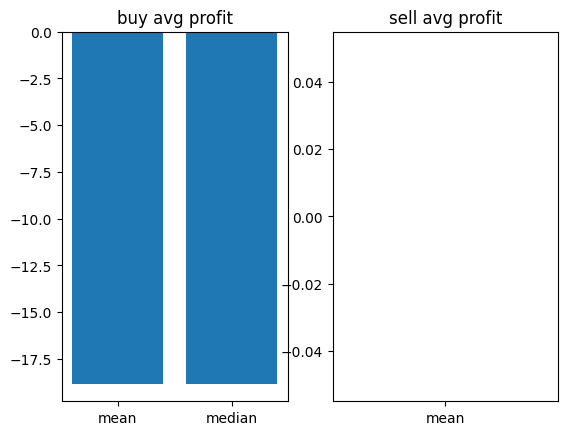

In [8]:

def plot_avg_profit(profit_df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    buy_data = {'mean': profit_df[profit_df['signal'] == 1]['profit'].mean(), 
                'median': profit_df[profit_df['signal'] == 1]['profit'].median()}
    sell_data = {'mean': profit_df[profit_df['signal'] == -1]['profit'].mean(), 
                'median': profit_df[profit_df['signal'] == -1]['profit'].median()}
    ax1.bar(*zip(*buy_data.items()))
    ax1.set_title('buy avg profit')
    ax2.bar(*zip(*sell_data.items()))
    ax2.set_title('sell avg profit')
    plt.show()


plot_avg_profit(profit_df)

## Signal counts

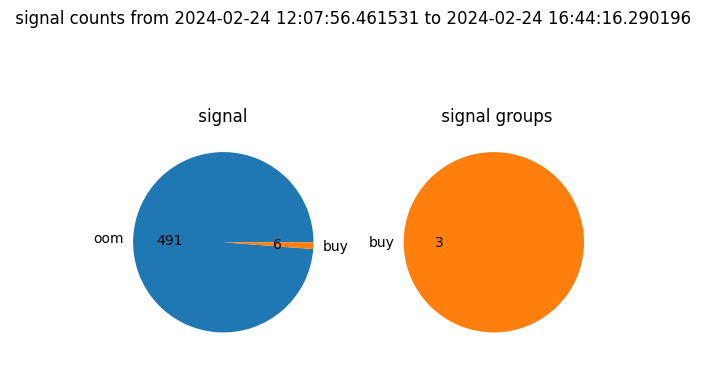

In [9]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped, name):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{name} {col} {tag}")
    
def plot_signal_counts(df, name = ''):
    #df = df.groupby('close_time').agg('last')
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False, name=name)
    plot_value_counts(ax2, df, 'signal', grouped = True, name=name)
    fig.suptitle(f'{name} signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

plot_signal_counts(signal_df)

## Profits and losses

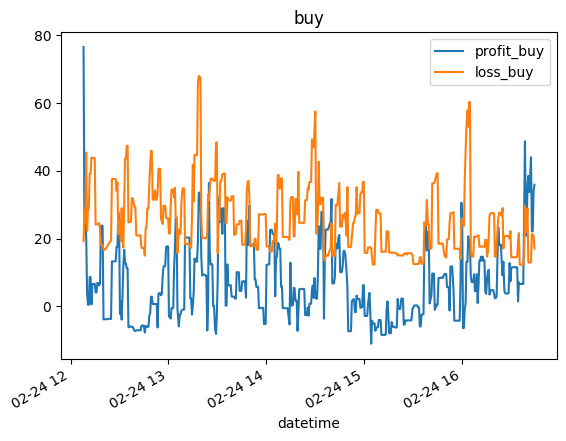

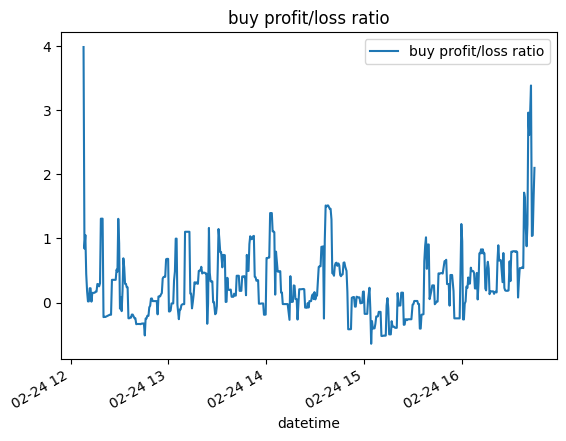

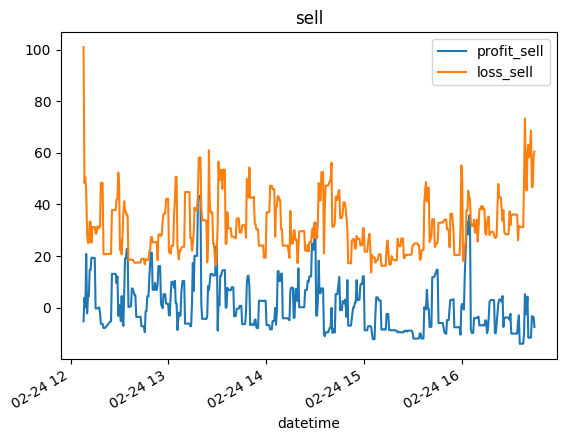

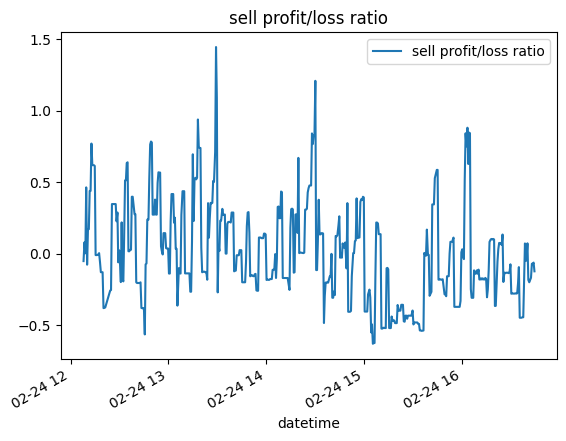

In [10]:
def plot_profit_loss(signalname):
    signal_df[[f'profit_{signalname}', f'loss_{signalname}']].plot(title=signalname)
    plt.show()
    ratio_df = pd.DataFrame(index=signal_df.index)
    ratio_df[f'{signalname} profit/loss ratio'] = (signal_df[f'profit_{signalname}']/signal_df[f'loss_{signalname}'])
    ratio_df.plot(title=f'{signalname} profit/loss ratio')
    plt.show()
plot_profit_loss('buy')
plot_profit_loss('sell')

## Profit/loss ratio

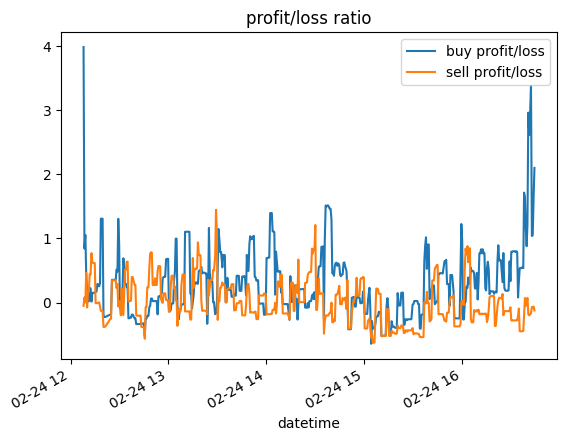

In [11]:
ratio_df = pd.DataFrame(index=signal_df.index)
ratio_df['buy profit/loss'] = (signal_df['profit_buy']/signal_df['loss_buy'])
ratio_df['sell profit/loss'] = (signal_df['profit_sell']/signal_df['loss_sell'])
ratio_df.plot(title='profit/loss ratio')

plt.show()


In [20]:
signal_df['status'].tail()

datetime
2024-02-24 16:42:08.948730    NaN
2024-02-24 16:42:41.868104    NaN
2024-02-24 16:43:12.998615    NaN
2024-02-24 16:43:45.287241    NaN
2024-02-24 16:44:16.290196    NaN
Name: status, dtype: object

## Prices

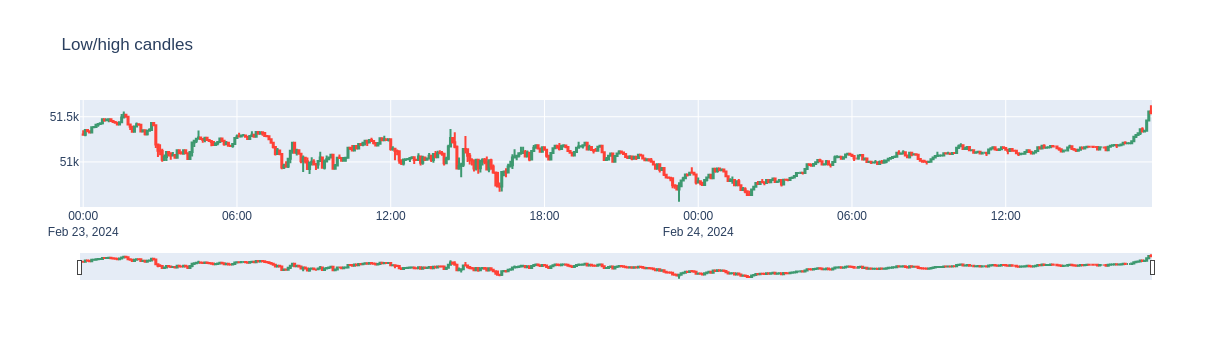

In [12]:
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def plot_candles_figure(signal_df: pd.DataFrame, candles: pd.DataFrame, period: str)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    df = candles
    #df=signal_df.resample(period).agg('last')
    #df = df.merge(candles)
    
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['close'].shift(1),\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])
    

    fig.update_layout(title_text='Low/high candles')                         
    fig.show()

plot_candles_figure(signal_df, candles,  '5min')

Read 3736 data y_pred rows  from 0 to 3735


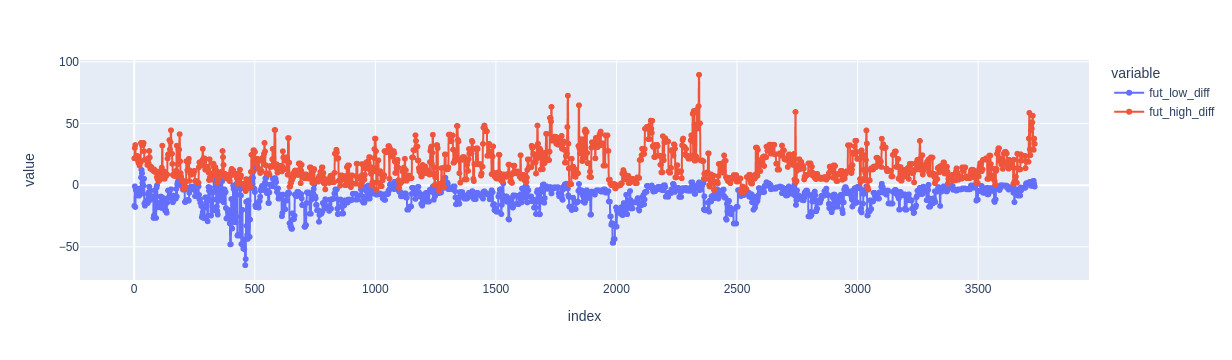

In [13]:
def analyze_y():
    df = read_last_data('y_pred', 1)#.set_index('datetime')
    px.line(df[['fut_low_diff', 'fut_high_diff']]).update_traces(mode='lines+markers').show()

#def analyze_raw_candles()
analyze_y()


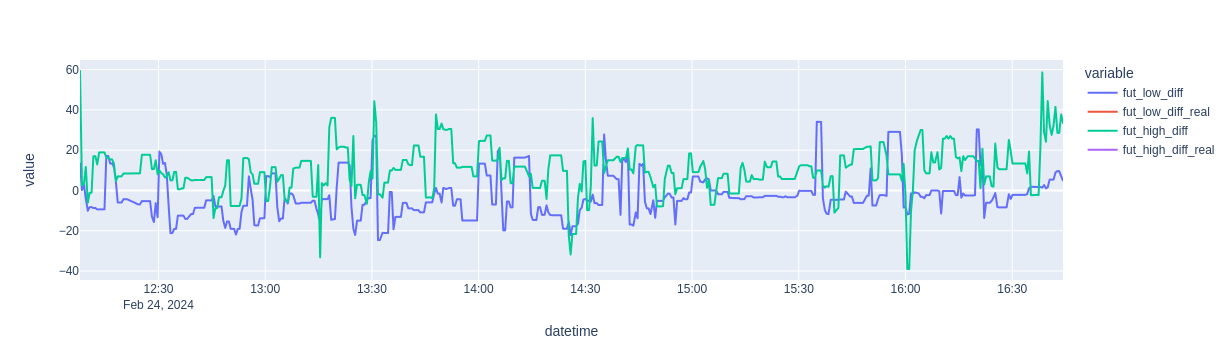

In [14]:
def analyze_signal_df():
    df = signal_df.copy()
    c = candles[['low','high']]
    df = pd.merge_asof(df, candles, left_index=True, right_index=True, direction='backward')
    df['fut_low_diff'] = df['fut_low'] - df['low']
    df['fut_high_diff'] = df['fut_high'] - df['high']
    df['fut_low_diff_real'] = candles['low'].shift(-1) - candles['low']
    df['fut_high_diff_real'] = candles['high'].shift(-1) - candles['high']
    df = df[['fut_low_diff', 'fut_low_diff_real', 'fut_high_diff', 'fut_high_diff_real']]
    px.line(df).show()
    
analyze_signal_df()    

## Real trading

### Trades

Get trades from ../data/yandex-cloud/LgbLowHighRegressionStrategy/LgbLowHighRegressionStrategy.db


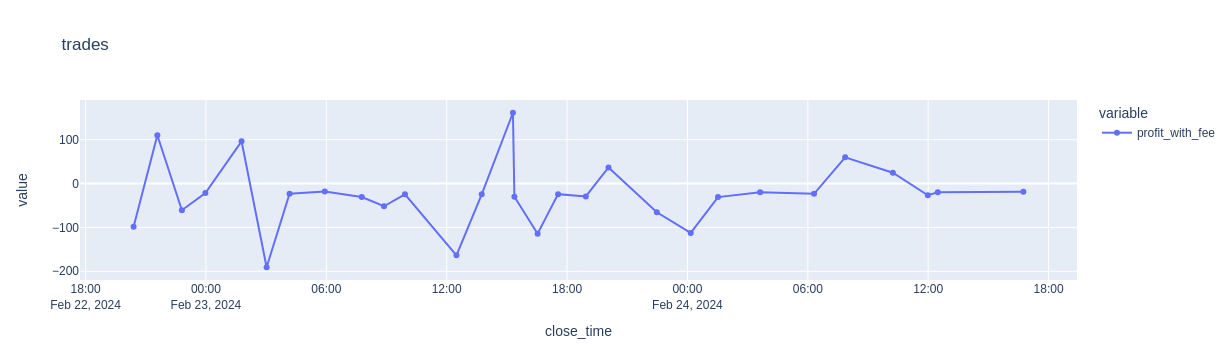

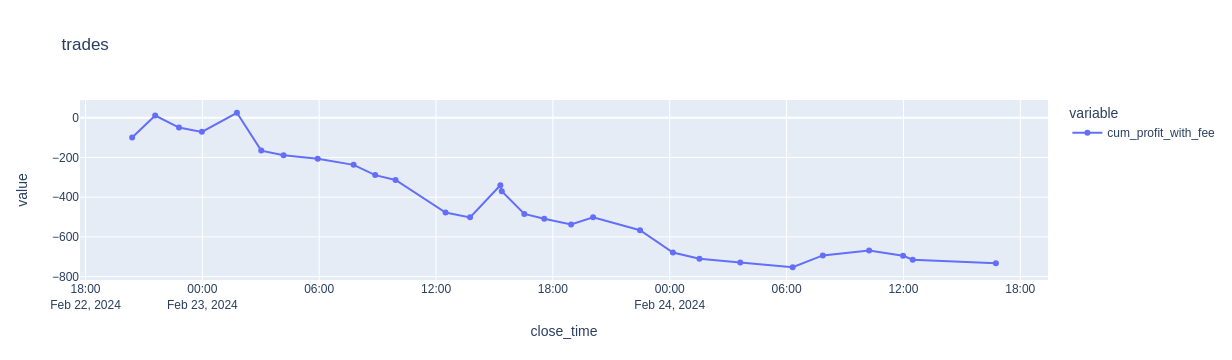

In [15]:
import pandas as pd
import numpy as np

def get_trades(data_dir: str, strategy: str):
    import sqlite3
    db_path=f"{data_dir}/{strategy}.db"
    fee=0.00012
    print(f"Get trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"]*quantity_coeff,
                                (trades["open_price"]-trades["close_price"])*trades["quantity"]*quantity_coeff,
                               )
    trades["cum_profit"] = trades["profit"].cumsum()
    trades["profit_with_fee"] = trades["profit"] - fee*(trades["open_price"] + trades["close_price"])*trades["quantity"]*quantity_coeff
    trades["cum_profit_with_fee"] = trades["profit_with_fee"].cumsum()
    trades=trades.set_index("close_time", drop=False)
    return trades

trades=get_trades(data_dir, strategy)
px.line(trades["profit_with_fee"], title="trades").update_traces(mode='lines+markers').show()
px.line(trades["cum_profit_with_fee"], title="trades").update_traces(mode='lines+markers').show()

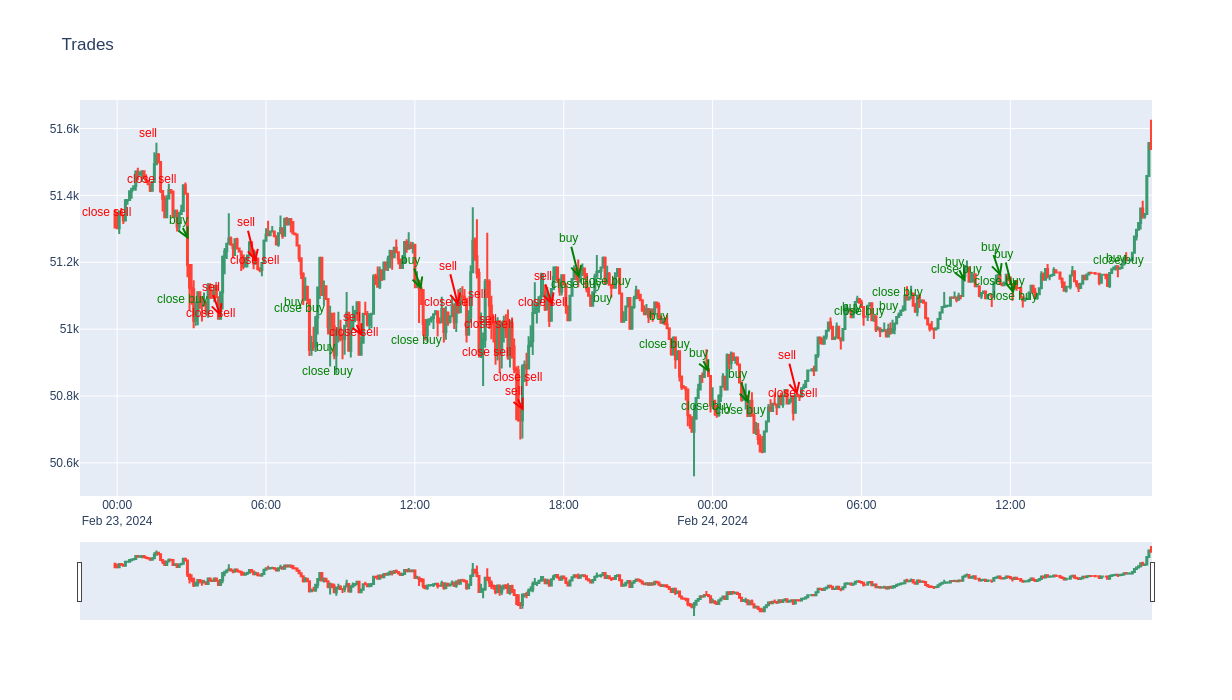

In [16]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def plot_trades_on_candles(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades["open_time"].isna()) & \
                           (trades["open_time"] > df.open_time.min()) & \
                           (~trades.close_time.isna()) & \
                           (~trades.open_price.isna()) & \
                           (~trades.close_price.isna()) \
                         ].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                         )
    for i,trade in trades[(~trades.close_time.isna()) & \
                          (~trades.open_price.isna()) & \
                          (~trades.close_price.isna()) & \
                          (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text=f"close {trade['side'].lower()}"
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,\
                           font={'color':color}
                         )
        fig.update_layout(title="Trades")
        fig.update_layout(height=700)
        
    fig.show()

plot_trades_on_candles(candles, trades)



### Account

Reading balance files from ../data/yandex-cloud/LgbLowHighRegressionStrategy/account


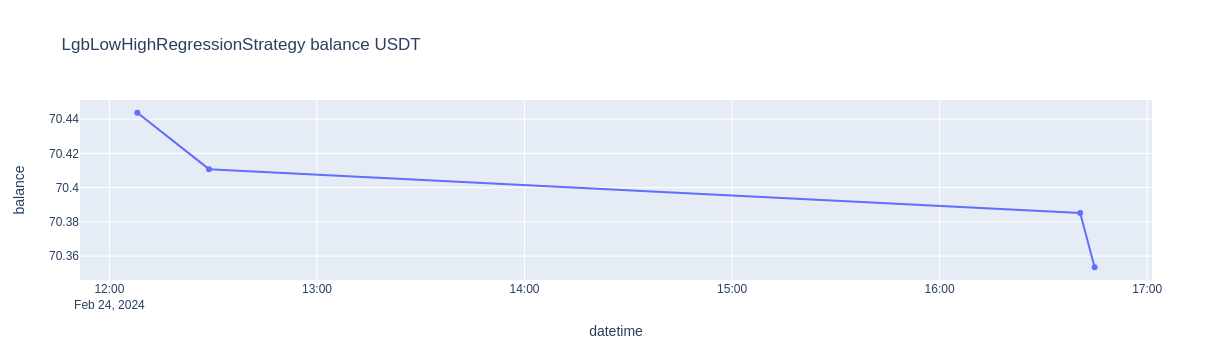

In [17]:
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

plot_figsize=(10,5)
sns.set_style("darkgrid")
from datetime import datetime


def get_balance(strategy: str):
    """ Read balance history from data"""
    
    data_dir=f"../data"
    env_dir="yandex-cloud"
    account_dir=f"{data_dir}/{env_dir}/{strategy}/account"
    print(f"Reading balance files from {account_dir}")
    #file_path = sorted([f for f in os.listdir(account_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
    files = sorted([f for f in os.listdir(account_dir) if f.endswith(f".csv.zip")])
    dfs = [pd.read_csv(f"{account_dir}/{f}", parse_dates=True, index_col="time") for f in files]
    df = pd.concat(dfs).sort_index() if dfs else pd.DataFrame(data=[{"datetime": datetime.now(), "balance": 0}], columns=["datetime","balance"])
    #df = pd.concat([df for df in dfs if not df.empty]).sort_index()
    df["datetime"] = df.index
    df = df[df['balance'].diff()!=0]
    return df[df.index >= min(signal_df.index)]

balance = get_balance(strategy)
px.line(balance, "datetime", "balance", title=f"{strategy} balance USDT").update_traces(mode='lines+markers').show()